# Basic classification
<hr>

옷, 신발, 셔츠 같은 이미지를 분류하기 위한 튜토리얼으로 tensorflow 를 훝어보기 위한 것이다. 자세한 설명은 여기서는 다루지 않는다.

In [2]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.11.0


## Import the Fashion MNIST

여기서는 [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist)을 사용하며, 70,000 개의 grayscale 이미지(28 x 28 pixels)와 10개의 카테고리로 이루어진다. 

![figure1](https://tensorflow.org/images/fashion-mnist-sprite.png)
*<b>Figure 1.</b> Fashion-MNIST samples (by Zalando, MIT License).*

...

60,000 이미지로 network를 학습시키고, 10,000 이미지로 학습한 network가 분류를 얼마나 정확히 하는지를 평가할 것이다.

In [15]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

위의 load_data()로 인해, 4개의 NumPy array를 리턴한다:
- train_images와 train_labels은 training set으로, model을 학습시키는데 사용된다.
- 그 model은 test set인 test_images, test labels에 의해 테스트된다.

이미지의 label은 각각 다음의 class에 매칭이 된다:

|Label|Class|
|--|--|
0|T-shirt/top
1|Trouser
2|Pullover
3|Dress
4|Coat
5|Sandal
6|Shirt
7|Sneaker
8|Bag
9|Ankle boot

데이터셋에 class이름을 포함하고 있지 않기 때문에 이것을 담아주자

In [18]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Explore the data

model을 학습하기 전, 60,000개의 이미지가 28 x 28 필셀로 나타나 있는 것을 들여다 보자

In [19]:
train_images.shape

(60000, 28, 28)

In [29]:
len(train_labels)

60000

labels 내 각 label은 0과 9사이의 정수로 이루어져 있다.

In [22]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

test set 또한 위와 마찬가지

In [23]:
test_images.shape

(10000, 28, 28)

In [24]:
len(test_labels)

10000

## Preprocess the data

network를 학습하기 전, 데이터는 반드시 전처리(preprocess)되어야 한다. training set의 첫 이미지를 들여다 보면, pixel의 값이 0~255 사이의 값인 것을 확인할 수 있다.

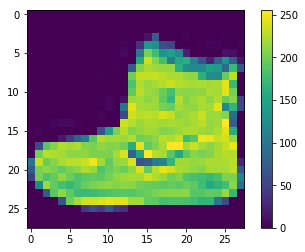

In [31]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)

뉴럴넷 모델에 데이터를 넣기 전, 이러한 값들을 0~1 사이의 값으로 변환해야 한다. 그러기 위해서는 int에서 float로 바꿔야 하고 이를 255로 나누어야 한다. 

**NOTE**: 중요한 점은, traing set과 test set이 같은 방법으로 전처리 되어야 하다는 것이다.

In [32]:
train_images = train_images / 255.0
test_images = test_images / 255.0

처음 25개의 이미지를 각 하단에 클래스명을 함께 띄워 확인해보고, 데이터가 네트워크를 학습할 준비가 된 정확한 format인지를 확인해 보자

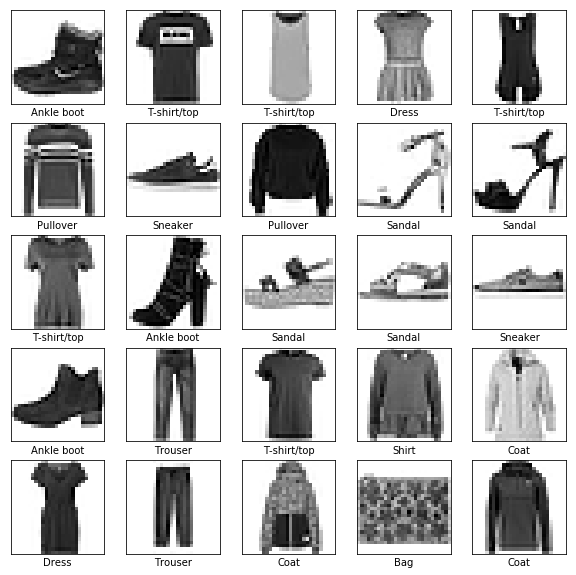

In [34]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary) # cmap? =colormap
    plt.xlabel(class_names[train_labels[i]])    

## Build the model

뉴럴넷을 빌드하는 것?
- model의 layer를 설정(configuring) 하는 것
- model을 컴파일링 하는 것

### Setup the layers

뉴럴넷의 가장 근본적인 building block은 layer이다. Layer는 data로부터 representation들을 추출하여 그것들을 흡수하는데, 다행스럽게도 이런 representation들은 주어진 문제에 더욱 의미를 지닌다.

대부분의 딥러닝 간단한 layer들을 함께 chain한 것으로 구성되고, `tf.keras.layers.Dense` 같은 대부분의 layer들은 parameter를 지니며 이 parameter들이 training으로 학습된다.

In [38]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

**첫번째 레이어**: `keras.layers.Flatten`, 2d-array(28, 28)의 이미지를 1d-array 형태(28*28=784)로 바꾸는 역할을 한다. 이미지의 pixel를 일렬로 줄세워 row를 없애는 역할을 한다고 생각하자. data를 reformat할 뿐, learn할 parameter를 갖고 있지 않는다. 

**두번째 레이어**: `keras.layers.Dense`, 이건 densely-connected 혹은 fully-connected인 뉴럴 layer이다. 128개 node(neurons 라고도 함)를 가지는 것이다.

**세번째 레이어**: 10개 node를 가진 softmax-layer이고, 이것은 10개의 확률점수를 리턴한다. (그 10개의 점수의 합은 1) 각 노드는 현재 이미지가 10개의 class 중 어디에 속하는지의 확률을 나타낸다.

### Compile the model

모델을 학습시키기 전, 아직 세팅을 조금 더 해야 한다. compile 단계에서 다음이 추가되어야 한다:
- *Loss function* - training동안 model이 얼마나 정확한지를 측정하는 것으로, 우리가 model을 올바른 방향으로 "조정"하기 위해서는 이것을 최소화해야한다.
- *Optimizer* - data와 loss function을 기반으로 model을 어떻게 업데이트 시키느냐에 관한 것이다.
- *Metrics* - training과 testing 단계를 지켜보기 위함이다. 다음 예시에서는 accuracy(이미지를 제대로 분류했는지에 대한 분수)를 사용하였다.

In [40]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

### Train the model

뉴럴넷 model을 학습시키는 것은 다음의 과정을 따른다:    
1. training data를 model에 넣는다(feed) - *example에서 `train_images`와 `train_labels`*
2. model은 images와 labels을 연결하는 것을 학습한다.
3. model에게 test set으로 예상값(predictions)를 요청한다. *- example에서 `test_images`*. 그 값이 실제 label(*example-`test_labels`*)과 매칭하는 지를 보자.


In [43]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 7s 124us/step - loss: 0.5016 - acc: 0.8246
Epoch 2/5
60000/60000 [==============================] - 6s 97us/step - loss: 0.3737 - acc: 0.8658
Epoch 3/5
60000/60000 [==============================] - 6s 97us/step - loss: 0.3360 - acc: 0.8785
Epoch 4/5
60000/60000 [==============================] - 6s 96us/step - loss: 0.3131 - acc: 0.8858
Epoch 5/5
60000/60000 [==============================] - 6s 97us/step - loss: 0.2940 - acc: 0.8922


모델이 학습되었고, loss와 accuracy metrics가 표시되었다.  이 모델은 training data로 0.89(or 89%)에 이르는 accuracy를 보인다.

### Evaluate accuracy

학습한 model을 test dataset으로 수행시켜보자

In [44]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

10000/10000 [==============================] - 1s 62us/step
Test accuracy: 0.8704


training dataset에서의 accuracy보다 조금 더 적게 나온 것을 확인할 수 있다. 이러한 training과 testing에서의 accuracy 차이는 overfitting의 예시이다. Overfitting은 training data보다 새로운 data에서 더 안좋은 성능을 수행할때를 의미한다.

### Make predictions

학습된 model을 사용하여 몇몇 이미지들로 예측을 해볼 수 있다.

In [46]:
predictions = model.predict(test_images)

여기서, model은 testing set에서의 각 이미지들의 label을 예측하였다. 첫번째 예측을 들여다 보자.

In [48]:
predictions[0]

array([5.7816880e-05, 2.1413638e-07, 7.8823308e-07, 8.7470221e-07,
       8.4959011e-06, 8.0639292e-03, 3.3960085e-05, 3.9705250e-02,
       1.8653536e-04, 9.5194209e-01], dtype=float32)

한 prediction은 10개의 수로 이루어진 array이다. 이것들은 model에서 이미지가 10개의 다른 옷들과 일치하는지에 대한 "confidence"를 나타낸다. 우리는 어떤 label이 가장 높은 confidence를 가지는지를 확인할 수 있다:

In [49]:
np.argmax(predictions[0])

9

In [51]:
class_names[9]

'Ankle boot'

위 코드로, 이 사진이 Ankle boot에 가장 높은 확신(confident)을 가진다는 것을 알 수 있다. 또한 실제 test lable이 맞는지도 다음을 통해 확인해 볼 수 있다:

In [52]:
test_labels[0]

9

10개의 전체 채널들을 들여다 보기 위한 그래프로 나타낼 수 있다.

In [67]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), 
               color=color)
    
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

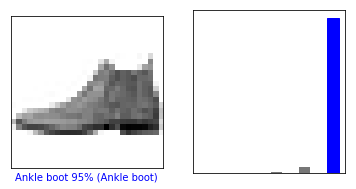

In [68]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

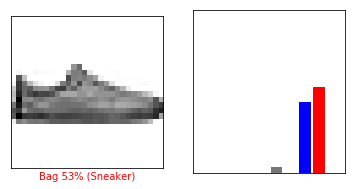

In [70]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Confidence가 매우 높게 나와도 틀린 예측값이 될 수도 있다는 것을 염려해 두자.

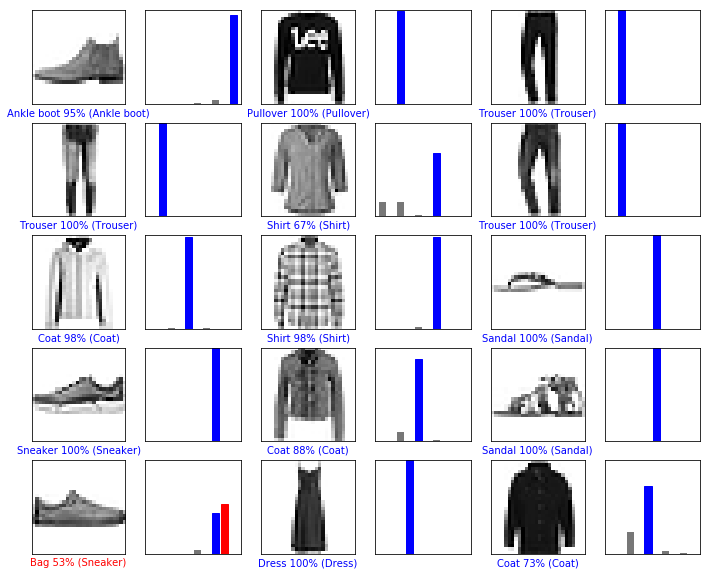

In [73]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)

마지막으로, 학습된 model을 사용하여 하나의 이미지를 예측해보자

In [76]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28)


`tf.keras` model는 example들의 batch 혹은 collection으로 예측하는데에 최적화되어있다. 그러므로, 하나의 이미지만을 사용할지라도, list에 추가할 필요가 있다.

In [79]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


이제 이미지를 예측해보자

In [80]:
predictions_single = model.predict(img)

print(predictions_single)

[[5.7816880e-05 2.1413659e-07 7.8823308e-07 8.7470141e-07 8.4959011e-06
  8.0639245e-03 3.3960085e-05 3.9705239e-02 1.8653536e-04 9.5194209e-01]]


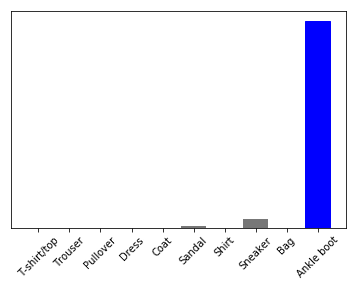

In [82]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`model.predict` 는 list들의 list를 반환하며, 각 list 하나는 batch에서 한 이미지를 나타낸다. batch에서 한 이미지에 대한 예측을 추출해보자:

In [87]:
np.argmax(predictions_single[0])

9

이전에 9를 예측한 것과 같다.

### Reference

Translated on december 26, 2018.

https://www.tensorflow.org/tutorials/keras/basic_classification